# Coaches notebook
The main focus of this notebook is
- calculate the coaches power rank based on information inside `coaches.csv` dataset 
- generate `coaches_final` dataset that groups the coaches powerrank in a team at a year that he/she coached that team. There is a formula for when there is more than one coach in the same team at the same year that will be explained below.  

## Section: Data loading and exploration

This section focuses on loading the necessary datasets for further analysis and processing.Initial exploration is conducted to understand the structure and content of the datasets (especially the coaches dataset). The process involves:
- import ``coaches``, ``awards_coaches`` and ``teams`` datasets.
- identify missing values in coaches dataset
- create a scatter plot to explore the distribution and potential patterns between wins and losses for coaches.
- create horizontal bar chart to provide an overview of the diversity of values in different columns of the ``coaches`` dataset.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

coaches = pd.read_csv('basketballPlayoffs/coaches.csv', delimiter=",")
awards_coaches = pd.read_csv('basketballPlayoffs/awards_coaches.csv', delimiter=",")
teams_for_coaches = pd.read_csv('basketballPlayoffs/teams.csv', delimiter=",")


print(coaches['coachID'].nunique()) 

print(coaches.head())

coaches.isnull().sum()


57
      coachID  year tmID  lgID  stint  won  lost  post_wins  post_losses
0  adamsmi01w     5  WAS  WNBA      0   17    17          1            2
1  adubari99w     1  NYL  WNBA      0   20    12          4            3
2  adubari99w     2  NYL  WNBA      0   21    11          3            3
3  adubari99w     3  NYL  WNBA      0   18    14          4            4
4  adubari99w     4  NYL  WNBA      0   16    18          0            0


/home/ze/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


coachID        0
year           0
tmID           0
lgID           0
stint          0
won            0
lost           0
post_wins      0
post_losses    0
dtype: int64

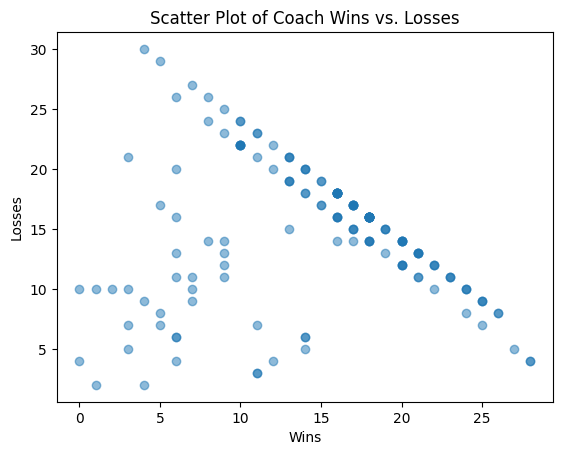

In [2]:
# Extract the wins and losses data from the "won" and "lost" columns
coach_wins = coaches['won']
coach_losses = coaches['lost']

# Create a scatter plot
import matplotlib.pyplot as plt

plt.scatter(coach_wins, coach_losses, alpha=0.5)
plt.xlabel('Wins')
plt.ylabel('Losses')
plt.title('Scatter Plot of Coach Wins vs. Losses')
plt.show()


In [3]:
for column in coaches.columns:
    unique_values = coaches[column].unique()
    print(f"Number of different values in the {column} column are:", len(unique_values))
    print("------------")

Number of different values in the coachID column are: 57
------------
Number of different values in the year column are: 10
------------
Number of different values in the tmID column are: 20
------------
Number of different values in the lgID column are: 1
------------
Number of different values in the stint column are: 3
------------
Number of different values in the won column are: 29
------------
Number of different values in the lost column are: 28
------------
Number of different values in the post_wins column are: 8
------------
Number of different values in the post_losses column are: 6
------------


LeagueID there is just one value so we can erase that column. 

In [4]:
coaches = coaches.drop('lgID', axis=1)

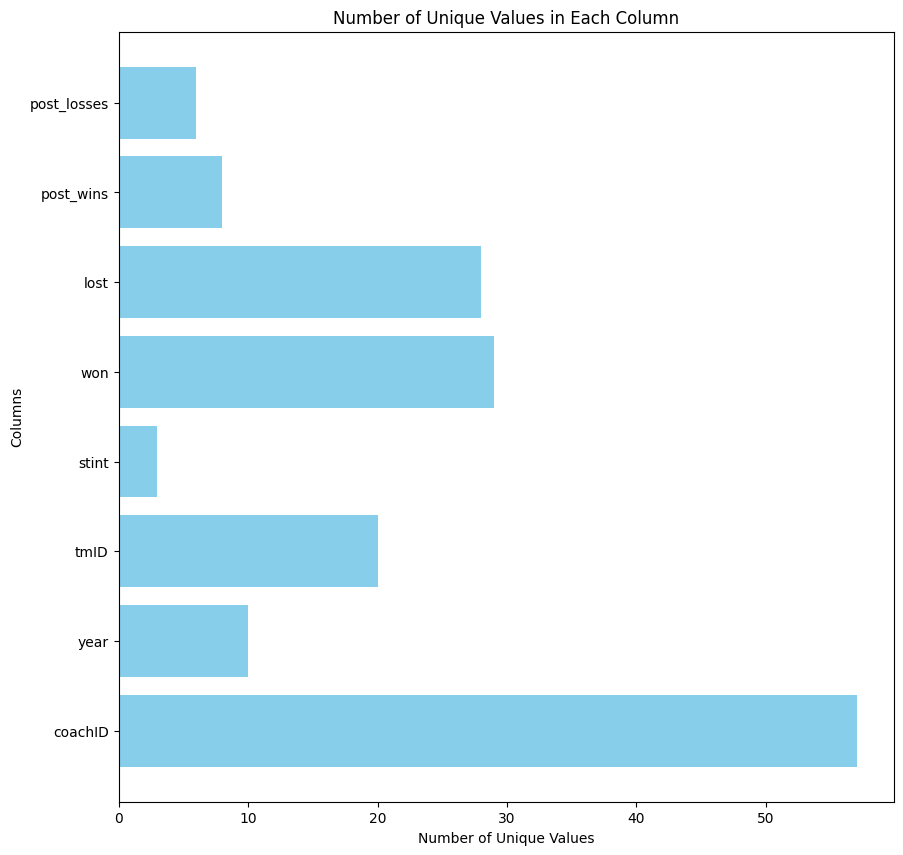

In [5]:
columns = []
value_counts = []

for column in coaches.columns:
    unique_values = coaches[column].nunique()
    columns.append(column)
    value_counts.append(unique_values)

plt.figure(figsize=(10, 10))
plt.barh(columns, value_counts, color='skyblue')
plt.xlabel('Number of Unique Values')
plt.ylabel('Columns')
plt.title('Number of Unique Values in Each Column')
plt.show()

Feature analysis and types and also check for null values existance, not much as can be seen.

In [6]:
coaches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   coachID      162 non-null    object
 1   year         162 non-null    int64 
 2   tmID         162 non-null    object
 3   stint        162 non-null    int64 
 4   won          162 non-null    int64 
 5   lost         162 non-null    int64 
 6   post_wins    162 non-null    int64 
 7   post_losses  162 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 10.2+ KB


## Section: Get coaches of the year
This section focuses on the integration of `coach_awards` dataset into the coaches dataset, specifically identifying coaches who have won the "Coach of the Year" award in a given year. 
The process involves:
- dropping unnecessary columns: lgID
- merging coaches with awards_coaches
- create a binary indicator ('coachOfYear') to highlight award-winning coaches.

In [7]:
awards_coaches = awards_coaches.drop(['lgID'], axis=1)

# Merge the tables
coaches = pd.merge(coaches, awards_coaches, on=['coachID', 'year'], how='left')

# Fill NaN values with 0 in the countAward column
coaches['coachOfYear'] = coaches['award'].notna().astype(int)
coaches = coaches.drop('award', axis=1)

# Example usage
print(coaches)

        coachID  year tmID  stint  won  lost  post_wins  post_losses   
0    adamsmi01w     5  WAS      0   17    17          1            2  \
1    adubari99w     1  NYL      0   20    12          4            3   
2    adubari99w     2  NYL      0   21    11          3            3   
3    adubari99w     3  NYL      0   18    14          4            4   
4    adubari99w     4  NYL      0   16    18          0            0   
..          ...   ...  ...    ...  ...   ...        ...          ...   
157  wintebr01w     6  IND      0   21    13          2            2   
158  wintebr01w     7  IND      0   21    13          0            2   
159  wintebr01w     8  IND      0   21    13          3            3   
160  zierddo99w     8  MIN      0   10    24          0            0   
161  zierddo99w     9  MIN      0   16    18          0            0   

     coachOfYear  
0              0  
1              0  
2              0  
3              0  
4              0  
..           ...  
15

## Section: Calculate coaches power rank

In this section, the coaches' power ranking is computed based on their performance metrics available on the coaches ``dataset`` and their awards. The process involves:

- establish the highest and lowest values for features (wins, losses, post-season wins, post-season losses).
- define weights for each feature to influence the power ranking calculation.
- iterate through the coach dataset to identify extreme values and compute individual ratings for each coach.
- apply the established weights to calculate the power ranking accumulator for each coach.
- create a new column ``coachesPowerRanking`` in the coaches dataset to store the computed power rankings.

In [8]:
# highest and lowest value per feature to calculate rating (0-100)
wonMax = 0
wonMin = 999

lostMax = 0
lostMin = 999

postWinsMax = 0
postWinsMin = 999

postLossesMax = 0
postLossesMin = 999


# Weights for each feature
won_weight = 1.5
lost_weight = 1.0
post_wins_weight = 1.2
post_losses_weight = 1.0
award_weight = 50

for index, row in coaches.iterrows():
    if (row['won']) > wonMax:
        wonMax = row['won']
    if (row['won']) < wonMin:
        wonMin = row['won']

    if (row['lost']) > lostMax:
        lostMax = row['lost']
    if (row['lost']) < lostMin:
        lostMin = row['lost']

    if (row['post_wins']) > postWinsMax:
        postWinsMax = row['post_wins']
    if (row['post_wins']) < postWinsMin:
        postWinsMin = row['post_wins']

    if (row['post_losses']) > postLossesMax:
        postLossesMax = row['post_losses']
    if (row['post_losses']) < postLossesMin:
        postLossesMin = row['post_losses']

def coach_power_ranking(coach):
    wonRating = ((coach['won'] - wonMin) / (wonMax - wonMin)) * 100
    lostRating = ((coach['lost'] - lostMin) / (lostMax - lostMin)) * 100
    postWinsRating = ((coach['post_wins'] - postWinsMin) / (postWinsMax - postWinsMin)) * 100
    postLossesRating = ((coach['post_losses'] - postLossesMin) / (postLossesMax - postLossesMin)) * 100

     # Apply weights to each feature
    wonRating *= won_weight
    lostRating *= lost_weight
    postWinsRating *= post_wins_weight
    postLossesRating *= post_losses_weight
    award_feature = coach['coachOfYear'] * award_weight

    relevantFeatures = [wonRating, lostRating, postWinsRating, postLossesRating]

    powerRankingAcummulator = wonRating - lostRating + postWinsRating - postLossesRating + award_feature


    return powerRankingAcummulator


coaches['coachesPowerRanking'] = coaches.apply(coach_power_ranking, axis=1)

## Section : Calculate Team-wise Coaches Power Rank


In this section, the coaches' power rankings are aggregated at the team and year level, considering the contributions of individual coaches. The process involves:

- create a new column ``total_games`` to store the total games coached by each coach.
- group coaches by team (``tmID``) and year to calculate the total team games.
- define function ``calculate_contribution`` to compute the contribution of each coach to the total power ranking based on the games coached.
- apply the contribution calculation function to each row and creating a new column ``contribution``.
- group coaches again by team and year to sum the contributions and obtain the final ``coachesPowerRanking``.
- save the resulting dataset as ``coaches_final.csv``. 

In [9]:
# Create a new column for total games coached by each coach
coaches['total_games'] = coaches['won'] + coaches['lost'] + coaches['post_wins'] + coaches['post_losses']
coaches.to_csv('coach_contribution_powerRank.csv', index=False)

# Group by tmID and year, then calculate the total team games
team_year_group = coaches.groupby(['tmID', 'year'])
coaches['total_team_games'] = team_year_group['total_games'].transform('sum')

# Function to calculate the contribution of each coach to the total power ranking
def calculate_contribution(row):
    if row['stint'] == 0:
        return row['coachesPowerRanking']
    else:
        return (row['total_games'] / row['total_team_games']) * row['coachesPowerRanking']

# Apply the contribution calculation function to each row
coaches['contribution'] = coaches.apply(calculate_contribution, axis=1)

# Group by tmID and year again to get the sum of contributions for each team in each year
result = coaches.groupby(['tmID', 'year']).agg({'contribution': 'sum'}).reset_index()
result.rename(columns={'contribution': 'coachesPowerRanking'}, inplace=True)


result.to_csv('coaches_final.csv', index=False)
# Display the result
print(result)


    tmID  year  coachesPowerRanking
0    ATL     9           -78.571429
1    ATL    10            56.428571
2    CHA     1           -35.714286
3    CHA     2            42.142857
4    CHA     3            13.571429
..   ...   ...                  ...
137  WAS     6            28.571429
138  WAS     7             6.428571
139  WAS     8            36.974790
140  WAS     9            -6.302521
141  WAS    10           -11.428571

[142 rows x 3 columns]
